<a href="https://colab.research.google.com/github/sharlynmuturi/Pytorch-Tutorial/blob/main/cnn_deep_learning_explained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 170M/170M [00:03<00:00, 48.7MB/s]


Epoch: 0 	 Batch: 400 	 Loss: 1.6876
Epoch: 0 	 Batch: 800 	 Loss: 1.4419
Epoch: 0 	 Batch: 1200 	 Loss: 1.2364
Epoch: 1 	 Batch: 400 	 Loss: 1.5447
Epoch: 1 	 Batch: 800 	 Loss: 1.2492
Epoch: 1 	 Batch: 1200 	 Loss: 1.4152
Epoch: 2 	 Batch: 400 	 Loss: 1.0999
Epoch: 2 	 Batch: 800 	 Loss: 1.1997
Epoch: 2 	 Batch: 1200 	 Loss: 1.2703
Epoch: 3 	 Batch: 400 	 Loss: 1.1278
Epoch: 3 	 Batch: 800 	 Loss: 1.2925
Epoch: 3 	 Batch: 1200 	 Loss: 1.3506
Epoch: 4 	 Batch: 400 	 Loss: 1.2801
Epoch: 4 	 Batch: 800 	 Loss: 1.0919
Epoch: 4 	 Batch: 1200 	 Loss: 1.1632
Epoch: 5 	 Batch: 400 	 Loss: 1.1619
Epoch: 5 	 Batch: 800 	 Loss: 1.1815
Epoch: 5 	 Batch: 1200 	 Loss: 1.3144
Epoch: 6 	 Batch: 400 	 Loss: 1.0004
Epoch: 6 	 Batch: 800 	 Loss: 1.1133
Epoch: 6 	 Batch: 1200 	 Loss: 1.5512
Epoch: 7 	 Batch: 400 	 Loss: 1.3401
Epoch: 7 	 Batch: 800 	 Loss: 1.1474
Epoch: 7 	 Batch: 1200 	 Loss: 1.1107
Epoch: 8 	 Batch: 400 	 Loss: 1.0928
Epoch: 8 	 Batch: 800 	 Loss: 1.0831
Epoch: 8 	 Batch: 1200 	 Loss:

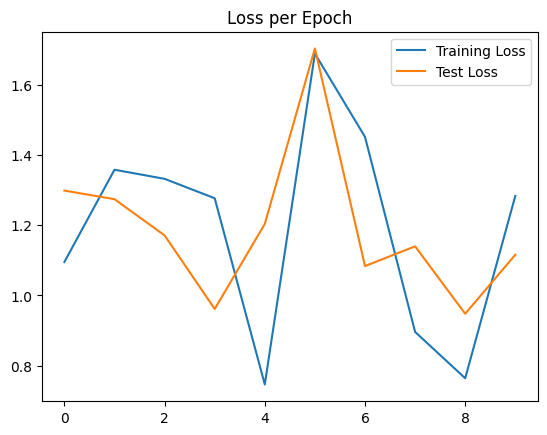

Final Test Accuracy: 0.6024


In [1]:
# CIFAR-10 CLASSIFICATION USING A CNN

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# TRANSFORMS (CIFAR-10 needs normalization (normalized_pixel = (pixel - mean) / std))
# Flips and augment (padding=4 pixels on each side, then randomly crops back to 32×32) before converting to tensors
# PyTorch models expect float tensors ie scales [0,1], (image pixels are in range[0, 255])
# PIL H×W×C image (or NumPy array) to a torch.Tensor with shape [C, H, W].
# Normalization with commonly used values or per-channel means (R,G,B) and per-channel std deviations.
# values are calculated over the CIFAR-10 training set (float in 0–1 scale).

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2023, 0.1994, 0.2010)
    )
])


# LOADING CIFAR-10 DATASET (same structure as MNIST)

train_data = datasets.CIFAR10(root='cifar_data', train=True,
                              download=True, transform=transform)

test_data = datasets.CIFAR10(root='cifar_data', train=False,
                             download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


# CNN MODEL (same style as MNIST but input channels=3)
# CIFAR-10 images are RGB, so first conv layer must take 3 channels.
# Also input size is 32x32, so the flattened dimension changes.

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # MNIST used Conv2d(1,6,...) because MNIST is grayscale
        # CIFAR-10 has 3 channels → Conv2d(3,6,...)
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)

        # After two conv + two maxpools:
        # 32x32 → pool → 16x16 → pool → 8x8 output
        # so flatten size = 16 filters * 8 * 8 pixels
        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)   # 10 CIFAR-10 classes

    def forward(self, X):
        X = F.relu(self.conv1(X))      # conv1 → relu
        X = F.max_pool2d(X, 2, 2)      # reduce to 16×16

        X = F.relu(self.conv2(X))      # conv2 → relu
        X = F.max_pool2d(X, 2, 2)      # reduce to 8×8

        # flatten features
        X = X.view(-1, 16 * 8 * 8)

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)

# INITIALIZE MODEL, LOSS, OPTIMIZER

torch.manual_seed(41)
model = CIFAR10_CNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# TRAINING LOOP (same structure as MNIST)

import time

start_time = time.time()
epochs = 10    # CIFAR-10 needs more epochs than MNIST
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # TRAINING
    model.train()
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        # Forward pass
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        trn_corr += (predicted == y_train).sum()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 400 == 0:
            print(f'Epoch: {i} \t Batch: {b} \t Loss: {loss.item():.4f}')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # TESTING
    model.eval()
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)

# TRAINING TIME

total_time = time.time() - start_time
print(f"\nTotal Training Time: {total_time:.2f} seconds\n")


# PLOTTING LOSS CURVES

train_losses = [t.detach().numpy() for t in train_losses]
test_losses = [t.detach().numpy() for t in test_losses]

plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

# TEST ACCURACY

test_load = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load:
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test).sum()

accuracy = correct.item() / len(test_data)
print(f"Final Test Accuracy: {accuracy:.4f}")


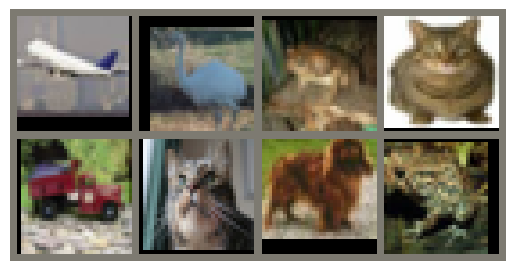

In [2]:
# Visualizing a batch of training images by creating a grid and reversing the normalization applied during preprocessing.

import torch
import matplotlib.pyplot as plt
import numpy as np

mean = np.array([0.4914, 0.4822, 0.4465])
std  = np.array([0.2023, 0.1994, 0.2010])

def unnormalize(img_tensor):
    """ img_tensor: torch.Tensor shape [C,H,W] (normalized). Returns HxWxC numpy in [0,1]. """
    img = img_tensor.clone().cpu().numpy()
    img = np.transpose(img, (1,2,0))   # C,H,W -> H,W,C
    img = (img * std) + mean           # reverse normalize (std and mean are broadcasted)
    img = np.clip(img, 0, 1)
    return img

# Example: display a batch
from torchvision.utils import make_grid
batch = next(iter(train_loader))[0]  # images tensor [B, C, H, W]
grid = make_grid(batch[:8], nrow=4)  # grid of first 8 imgs
plt.imshow(unnormalize(grid))
plt.axis('off')
plt.show()


In [3]:
# Pass image through the model

import torch

classes = train_data.classes

model.eval()

# get one CIFAR-10 sample
image, label = test_data[0]  # already transformed (3x32x32)

with torch.no_grad():
    output = model(image.view(1, 3, 32, 32))  # add batch dimension
    pred_idx = output.argmax(dim=1).item()

print("Raw logits:", output)
print("Predicted class index:", pred_idx)
print("Predicted label:", classes[pred_idx])
print("True label:", classes[label])


Raw logits: tensor([[-4.2498, -7.0543, -2.9903, -0.5445, -6.3088, -1.3282, -2.4911, -6.4901,
         -5.7517, -8.4708]])
Predicted class index: 3
Predicted label: cat
True label: cat


In [4]:

# Deploying

from google.colab import files
uploaded = files.upload()

import torch
from PIL import Image
import torchvision.transforms as transforms

# CIFAR-10 class list
classes = train_data.classes

# Transforms (no augmentation for inference)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2023, 0.1994, 0.2010)
    ),
])

img = Image.open("airplane_image.jpg").convert("RGB")

# Apply transforms Preprocess and reshape it to include a batch dimension for model input.
img_tensor = transform(img).unsqueeze(0)  # shape: (1, 3, 32, 32)

# Predict
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    probs = torch.softmax(output, dim=1)
    pred_idx = probs.argmax(dim=1).item()

# Print result
print("Predicted class:", classes[pred_idx])
print("Confidence:", probs[0][pred_idx].item())

Saving airplane_image.jpg to airplane_image.jpg
Predicted class: airplane
Confidence: 0.9851372241973877
